In [1]:
import os, glob
import pandas as pd
from helper import *
import datetime
import numpy as np
from sklearn import preprocessing
import statsmodels.formula.api as smf
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

pwd = os.path.dirname(os.path.realpath('.'))
data_folder = pwd + '/Data'
data_2018 = data_folder + '/2018'

In [2]:
list_of_speed_files_2018 = glob.glob(data_2018+'/speed_for_chunks/*')
list_of_csv_files_2018 = glob.glob(data_2018+'/2018_results/*')
annotations = pd.read_excel(data_2018+'/annotation.xlsx')
# len(list_of_csv_files_2018)

In [3]:
#  filter unvalid files
annotations = annotations[annotations.is_valid == 'Y']

In [4]:
name_of_csv_files_2018 = [i.split('/')[-1].split('.')[0] for i in list_of_csv_files_2018]
valid_files = [i for i in annotations.filename]
cnt = 0
for i in valid_files:
    if i in name_of_csv_files_2018:
        cnt += 1
assert cnt == len(valid_files), "Not all the files found!"

In [5]:
cnt = 0
dataset = pd.DataFrame()
not_processed = []
for j in annotations.filename:
    for i in name_of_csv_files_2018:
        if i == j:
            print("Processing file: ", j)
            try:
                file = [k for k in list_of_speed_files_2018 if k.split('/')[-1].split('.')[0][:-6] == j][0]
            except:
                print('Could not process ', j)
                print('Speed profile could not be found!')
                not_processed.append(j)
                break
            df_raw_speed = prepare_speed_profiles_for_model(file)

            file = [k for k in list_of_csv_files_2018 if k.split('/')[-1].split('.')[0] == j][0]

            df_detection = prepare_detections_for_model(file, df_raw_speed)
            df_detection = merge_speed_and_detection(df_detection, df_raw_speed, annotations, filename=i)

            dataset = pd.concat([dataset,df_detection])

            cnt += 1

    if cnt%10 == 0:
        print(len(list_of_speed_files_2018)-cnt, " files remained!")
        print(cnt, ' file processed!')

Processing file:  unit01_2018-09-26_20_38_20_1_2832
Processing file:  unit01_2018-09-26_22_29_30_1_7032
Processing file:  unit01_2018-09-26_22_29_30_4_28392
Processing file:  unit01_2018-09-26_23_17_50_3_25560
Processing file:  unit01_2018-10-17_15_03_17_15_83064
Processing file:  unit01_2018-10-18_15_22_15_1_66288
Processing file:  unit01_2018-10-19_21_13_40_1_1
Processing file:  unit01_2018-10-20_16_57_49_2_103512
Processing file:  unit01_2018-10-20_16_57_49_3_105384
Processing file:  unit01_2018-10-21_19_16_24_1_480
433  files remained!
10  file processed!
Processing file:  unit01_2018-10-21_19_16_24_2_2520
Processing file:  unit01_2018-10-21_22_59_02_1_1272
Processing file:  unit01_2018-10-21_22_59_02_2_12192
Processing file:  unit01_2018-10-21_22_59_02_4_20376
Processing file:  unit01_2018-10-22_20_55_26_8_257952


KeyboardInterrupt: 

In [ ]:
#dataset.to_csv('../Data/dataset.csv')

In [ ]:
#dataframe= pd.DataFrame(not_processed)
#dataframe.to_csv('../Data/not_processed.csv')

In [17]:
dataset = pd.read_csv('../Data/dataset.csv')
not_processed = pd.read_csv('../Data/not_processed.csv')

In [18]:
dataset = dataset[dataset.dist < 30]
dataset.dist = preprocessing.scale(dataset.dist)
dataset = dataset[dataset.Speed_MPH < 30]
dataset.Speed_MPH = preprocessing.scale(dataset.Speed_MPH)

In [19]:
dataset.columns = ['Unnamed:_0', 'frame_num', 'dist', 'center', 'datetime_time',
       'Speed_MPH', 'filename', 'vehicle_type', 'road_type']
dataset.vehicle_type = dataset.vehicle_type.map({'SUV': 'CAR', 'VAN': 'CAR' ,'PICKUP TRUCK': 'CAR',
                         'SEDAN': 'CAR', 'HEAVY TRUCK': 'HEAVY TRUCK', 
                         'FARM EQ': 'HEAVY TRUCK', 'BUS': 'HEAVY TRUCK'})

In [20]:
dataset = dataset.groupby('filename').filter(lambda x : len(x)>10)

In [21]:
md = smf.mixedlm("dist ~ Speed_MPH + C(vehicle_type) + C(road_type)",
                 dataset, groups=dataset["filename"], re_formula="1")
mdf_rand_intercept = md.fit()
print(mdf_rand_intercept.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist        
No. Observations:      86040        Method:                  REML        
No. Groups:            374          Scale:                   0.6115      
Min. group size:       12           Log-Likelihood:          -101689.0035
Max. group size:       1000         Converged:               Yes         
Mean group size:       230.1                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.375    0.099  3.798 0.000  0.181  0.568
C(vehicle_type)[T.HEAVY TRUCK] -0.219    0.089 -2.447 0.014 -0.394 -0.044
C(road_type)[T.PAVED]          -0.389    0.102 -3.797 0.000 -0.590 -0.188
Speed_MPH                       0.137    0.006 24.039 0.

In [22]:
md = smf.mixedlm("dist ~ Speed_MPH + C(vehicle_type) + C(road_type)",
                 dataset, groups=dataset["filename"], re_formula="-1 + Speed_MPH")
mdf_rand_slop = md.fit()
print(mdf_rand_slop.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist        
No. Observations:       86040        Method:                  REML        
No. Groups:             374          Scale:                   0.6818      
Min. group size:        12           Log-Likelihood:          -106597.4231
Max. group size:        1000         Converged:               Yes         
Mean group size:        230.1                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       0.479    0.010  46.500 0.000  0.459  0.499
C(vehicle_type)[T.HEAVY TRUCK] -0.278    0.012 -22.515 0.000 -0.302 -0.254
C(road_type)[T.PAVED]          -0.503    0.012 -41.442 0.000 -0.527 -0.479
Speed_MPH                       0.176    0.0

,Method,RMSE
0,Mixed_rand_intercept,0.780305


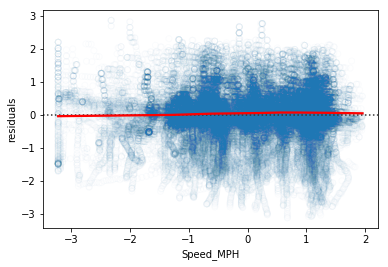

In [23]:
performance = pd.DataFrame()
performance["residuals"] = mdf_rand_intercept.resid.values
performance["Speed_MPH"] = dataset.Speed_MPH.values
performance["predicted"] = mdf_rand_intercept.fittedvalues.values
plt.figure()
sns.residplot(x = "Speed_MPH", y = "residuals", data = performance, lowess=True,
                   scatter_kws={'alpha':0.02, "facecolors":"None"},line_kws={'color': 'red'})
y_predict = mdf_rand_intercept.fittedvalues.values
y = dataset.dist.values
results = pd.DataFrame()
RMSE = math.sqrt(((y-y_predict)**2).mean())
results["Method"] = ["Mixed_rand_intercept"]
results["RMSE"] = RMSE
results

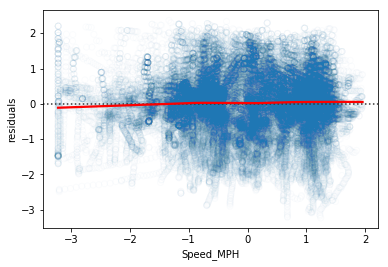

In [24]:
performance = pd.DataFrame()
performance["residuals"] = mdf_rand_slop.resid.values
performance["Speed_MPH"] = dataset.Speed_MPH.values
performance["predicted"] = mdf_rand_slop.fittedvalues.values
plt.figure()
ax = sns.residplot(x = "Speed_MPH", y = "residuals", data = performance, lowess=True, scatter_kws={'alpha':0.02, "facecolors":"None"}
                   , line_kws={'color': 'red'})
y_predict = mdf_rand_slop.fittedvalues.values
RMSE = math.sqrt(((y-y_predict)**2).mean())
results.loc[1] = ["Mixed_rand_slop", RMSE]

In [25]:
results

,Method,RMSE
0,Mixed_rand_intercept,0.780305
1,Mixed_rand_slop,0.823986


PAVED: red, GRAVEL: blue


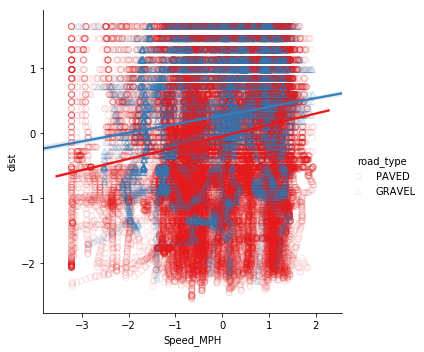

In [26]:
sns.lmplot(x = "Speed_MPH", y = "dist", data = dataset, scatter_kws={'alpha':0.1, 'facecolors':"None"},
           hue="road_type", markers=["o", "^"], palette="Set1")
print("PAVED: red, GRAVEL: blue")

CAR: red, HEAVY TRUCK: blue


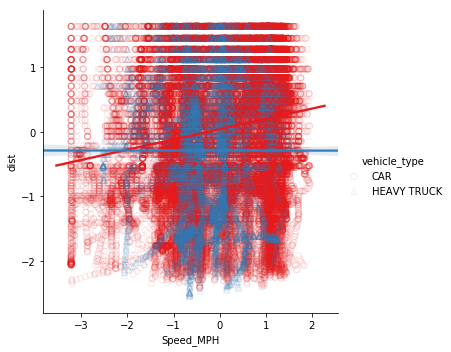

In [27]:
sns.lmplot(x = "Speed_MPH", y = "dist", data = dataset, scatter_kws={'alpha':0.1, 'facecolors':"None"},
           hue="vehicle_type", markers=["o", "^"], palette="Set1")
print("CAR: red, HEAVY TRUCK: blue")